# Official public work with private tools

The goal of this project is to extract the topics covered in the emails of Hillary Clinton. We start from a dirty database. That is why most of the preprocessing needs to be done from scratch.

Since we do not know the topics, there is no (easy) way to know whether or not the results are valid. Therefore, we will discover the topics using many different techniques and compare the output.

The first way will be naive and assume topics are based on regions in the world. We consider: Africa, Middle East, Central Asia, Russia, Europe, Far East, North America, Latino world. These features are set to `True` if at least one key word is related to the area. We will also use 2-grams words and cloud words to determine the content. We do not expect a high accuracy even if we cannot compute it.

The second technique is based on traditional machine learning algorithm to extract topics like what is provided in the last tutorial.

Both techniques will know the distribution of the dates because the same word does not have the same meaning in all contexts. For instance, what is the topic to be likely pointed by the word “Libya” during the NATO operation? What is the topic to be likely pointed by the same word during the murder of US ambassador in Libya?

Before doing anything, cleaning is required and it will take most of the part. Actually, this notebook is divided into two parts: 1. the cleaning and recovery, 2. the exploration and analysis.

Most of the analysis will be based on the content and date fields of the emails. But we will cover the network a little bit without digging it too much.

The minimum actions are:

1. 'To' and 'From' (who receives and sends emails) + cc if any

2. 'Date' (precise date of emails sending)

3. Extract content of emails (as good as possible) before preprocessing and cleaning

These three steps are the base of our analysis.

## Dataset

Our datasets are given by three main dataframes:

- Emails
- Persons
- Aliases
- EmailReceivers

The last one, EmailsReceivers is partially redundant (same information lies in emails dataframe) but it contains the 'cc' value(s) too.

The above dataframes essentially catch the following information, that will be important in our work.

### Persons

(Should) Provide a unique person identifier for each person.

### Aliases

A person can appear under many different names. For example "Hillary Clinton", "H", "Hillary", ... are linked to the table `persons`. We will see the wiring is not what it should have been. Of course, we assume there is only one Hillary among all the entries (roughly 500).

### Emails

We will see it later.

## Plan

1. Data Exploratory
    
    1.1. How clean `aliases` and `personId` are ? How are they related ? 
   
    1.2. how clean are `MetaDataTo` ('To') and `MetaDataFrom` ('From') in `emails`? are there missing values? 
    
    1.3. How are `aliases` and `personId` related in `emails` (`MetaDataTo` ('To') and `MetaDataFrom` ('From')) ?
    
    1.4. What is the behaviour of the content of `rawText`? (is it messy, multi-emails, etc)
        
2. Data Cleaning and Processing (algorithms explanation)

    2.1. Clean the `aliases` and `personId` relation
    
    2.2. Clean `To` and `From` features by processing and NaN filling
    
    2.3. Text cleaning for `rawText` (remove inappropriate lines)
    
    2.4. Text processing (lowcase, remove stopwords, remove short sentences, stemmatization, etc)
        
3. Results
               
    3.1. Emails time distribution

    3.2. Map emails to countries/regions
        
    3.3. WordCloud
        
    3.4. Research of topics
    
    3.5. Network

4. Future works

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk, re, string ,collections
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from datetime import datetime, date, time
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

from extractor import Extractor
from process import Process
from analyse import Analyse
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.

In [2]:
data_folder = "../data/"

The data is available in two formats: csv and sql. This means that the elements are somehow related. We will see later that the entity relationship diagram is not as it should have been done.

In [3]:
#Data extraction from the csv-files
emails_raw = pd.read_csv(data_folder + 'Emails.csv')
persons = pd.read_csv(data_folder + 'Persons.csv')
aliases = pd.read_csv(data_folder + 'Aliases.csv')
email_receivers = pd.read_csv(data_folder + 'EmailReceivers.csv')

In [4]:
print("emails:", emails_raw.shape)
print("persons:", persons.shape)
print("aliases:", aliases.shape)
print("email receivers:", email_receivers.shape)

emails: (7945, 22)
persons: (513, 2)
aliases: (850, 3)
email receivers: (9306, 3)


# Data exploratory

## How clean `aliases` and `personId` are? How are they related?

### Aliases

In [5]:
aliases.shape

(850, 3)

In [6]:
aliases.head()

Id                         Alias  PersonId
0   1                111th congress         1
1   2  agna usemb kabul afghanistan         2
2   3                            ap         3
3   4                      asuncion         4
4   5                          alec         5

In [7]:
aliases.PersonId.is_unique

False

In [8]:
aliases.Alias.is_unique

True

In [9]:
aliases.groupby('PersonId').count().shape

(513, 2)

In [10]:
aliases.sort_values(by='PersonId').head()

Id                         Alias  PersonId
0   1                111th congress         1
1   2  agna usemb kabul afghanistan         2
2   3                            ap         3
3   4                      asuncion         4
4   5                          alec         5

In [11]:
aliases[aliases['PersonId'] == 10]

Id                 Alias  PersonId
10    11    slaughter annmarie        10
11    12  slaughter anne marie        10
12    13   slaughter annemarie        10
13    14  slaughtera@state.gov        10
441  442   annemarie slaughter        10

In [12]:
aliases[aliases['Id'].isin([849,850])]

Id                 Alias  PersonId
848  849    hanle mr@state.gov       512
849  850  ha nleym r@state.gov       513

These two rows are not pointing towards the same person as we could reasonable expect to be the case. We investigate then into PersonId dataset.

### Persons

In [13]:
persons.shape

(513, 2)

In [14]:
persons.head()

Id                          Name
0   1                111th Congress
1   2  AGNA USEMB Kabul Afghanistan
2   3                            AP
3   4                      ASUNCION
4   5                          Alec

In [15]:
persons.Id.is_unique

True

In [16]:
persons.groupby('Name').count().shape

(513, 1)

In [17]:
persons.sort_values('Name').tail(20)

Id                                Name
311  312                valmorol1@state.gov.
293  294                valmorolj@state.gov.
380  381                 valmoroll@state.gov
269  270                valmoroll@state.gov.
418  419                  valmorou state. ov
271  272                  valmorou@state.gov
304  305                 valmorou@state.gov.
343  344                 valmorou@state.gove
439  440                  valmorou@state.goy
315  316                  valmorou©state.gov
347  348                 valmorou©state.gov.
419  420               vanbuskirk michael .3
348  349                vanbuskirk michael 1
442  443                     waxman sharon l
310  311                             wburns6
398  399                      williamsbarre0
423  424                      williamsbarret
368  369  williamsbarrett millscd@state.gov.
473  474                 woodardew@state.gov
341  342                 yeryeerms@state.goy

### Preliminary results

There are some evident mistakes in terms of unique persons ID. Sometimes, the same persons are considered to be different. The reason is essentially due to spelling mistakes. For instance, `monica.hanle' alias is not pointing towards the same identifier as `Monica Hanley' as one could reasonably expect. Solving this issue can be done through many algorithms like clustering by the Hammer distance and/or by the longest shared string. This would solve most of the wrong links but some exceptions would be uncaught. Since the number of rows is small, clustering the aliases manually is likely to take less time than implementing the algorithms with the exceptions. Eventually, we reduce the size of the persons table by around a third which is not negligible.

Moreover, it is quite easy to remark that the first \~220 Names are unique and are the main persons (with capital). We will therefore match the rest 300 with those names if it is evident.

In [18]:
persons.sort_values('Name').Name.tolist()[:10] # change this value to show more

['.',
 '. huma abedin',
 '. vermarr@state.gov',
 '..lilotylc@state.gov.',
 '.1ilotylc@state.gov',
 '.1ilotylc@state.gov.',
 '.filotylc@state.gov.',
 '.gordonph@state.gov.',
 '111th Congress',
 'AGNA USEMB Kabul Afghanistan']

### Remarks and Issues

`Aliases` is not to be unique per Aliases while `persons` is. Multiple obviously same Aliases point on different person. We have to handle this in order to have an effective database.

## Data cleaning Part

### Clean the `aliases` and `personId` relation

Here we create a new personId by fetching the persons that are obviously the same in order to handle the previous remarks/issues.

In [19]:
# We create manually the dictionary that will fetch same Person in a unique ID
from constant import dictionary_merge_name

In [20]:
swap_keys_person = {}
for k,v in dictionary_merge_name.items():
    for val in v:
        swap_keys_person[val] = k

def change_personId(swap_keys_person, x):
    try:
        name = swap_keys_person[x]
        personId = persons[persons.Name == name].Id.values[0]
        return personId
    except:
        personId = persons[persons.Name == x].Id.values[0]
        return personId

In [21]:
persons['newId'] = persons.Name.apply(lambda x: change_personId(swap_keys_person, x))

In [22]:
tmp = persons[persons.Id != persons.newId]
print("Number of persons who got a newId: " + str(tmp.shape[0]))
tmp.head()

Number of persons who got a newId: 173


Id                                Name  newId
30    31                              Cheryl     32
78    79                                Hill     80
229  230                   reines philippe f    170
230  231  sullivan jacob j nuland victoria 1     87
231  232                    russorv@stategov    185

In [23]:
print(persons.Id.nunique())
print(persons.newId.nunique())

513
340


### Results

Thanks to our strategy of cleaning person Id data, we could improve the dataset of personId by reducing the set from 513 to 340 persons. Reduction of around 30%.


## Data exploration in `emails` 


In [24]:
emails_raw.head()

Id  DocNumber                                    MetadataSubject  \
0   1  C05739545                                                WOW   
1   2  C05739546  H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...   
2   3  C05739547                                      CHRIS STEVENS   
3   4  C05739550                         CAIRO CONDEMNATION - FINAL   
4   5  C05739554  H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...   

     MetadataTo       MetadataFrom  SenderPersonId           MetadataDateSent  \
0             H  Sullivan, Jacob J            87.0  2012-09-12T04:00:00+00:00   
1             H                NaN             NaN  2011-03-03T05:00:00+00:00   
2            ;H    Mills, Cheryl D            32.0  2012-09-12T04:00:00+00:00   
3             H    Mills, Cheryl D            32.0  2012-09-12T04:00:00+00:00   
4  Abedin, Huma                  H            80.0  2011-03-11T05:00:00+00:00   

        MetadataDateReleased  \
0  2015-05-22T04:00:00+00:00   
1  2015-05-22T04:00:00+00:00   
2  2015-05-22T04:00:00+00:00   
3  2015-05-22T04:00:00+00:00   
4  2015-05-22T04:00:00+00:00   

                                     MetadataPdfLink MetadataCaseNumber  \
0  DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...       F-2015-04841   
1  DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...       F-2015-04841   
2  DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...       F-2015-04841   
3  DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...       F-2015-04841   
4  DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...       F-2015-04841   

                         ...                         ExtractedTo  \
0                        ...                                 NaN   
1                        ...                                 NaN   
2                        ...                                  B6   
3                        ...                                 NaN   
4                        ...                                 NaN   

                              ExtractedFrom         ExtractedCc  \
0  Sullivan, Jacob J <Sullivan11@state.gov>                 NaN   
1                                       NaN                 NaN   
2       Mills, Cheryl D <MillsCD@state.gov>        Abedin, Huma   
3       Mills, Cheryl D <MillsCD@state.gov>  Mitchell, Andrew B   
4                                       NaN                 NaN   

                        ExtractedDateSent ExtractedCaseNumber  \
0  Wednesday, September 12, 2012 10:16 AM        F-2015-04841   
1                                     NaN        F-2015-04841   
2  Wednesday, September 12, 2012 11:52 AM        F-2015-04841   
3   Wednesday, September 12,2012 12:44 PM        F-2015-04841   
4                                     NaN        F-2015-04841   

  ExtractedDocNumber ExtractedDateReleased ExtractedReleaseInPartOrFull  \
0          C05739545            05/13/2015              RELEASE IN FULL   
1          C05739546            05/13/2015              RELEASE IN PART   
2          C05739547            05/14/2015              RELEASE IN PART   
3          C05739550            05/13/2015              RELEASE IN PART   
4          C05739554            05/13/2015              RELEASE IN PART   

                                   ExtractedBodyText  \
0                                                NaN   
1  B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...   
2                                                Thx   
3                                                NaN   
4  H <hrod17@clintonemail.com>\nFriday, March 11,...   

                                             RawText  
0  UNCLASSIFIED\nU.S. Department of State\nCase N...  
1  UNCLASSIFIED\nU.S. Department of State\nCase N...  
2  UNCLASSIFIED\nU.S. Department of State\nCase N...  
3  UNCLASSIFIED\nU.S. Department of State\nCase N...  
4  B6\nUNCLASSIFIED\nU.S. Department of State\nCa...  

[5 rows x 22 columns]

In [25]:
emails_raw.dtypes

Id                                int64
DocNumber                        object
MetadataSubject                  object
MetadataTo                       object
MetadataFrom                     object
SenderPersonId                  float64
MetadataDateSent                 object
MetadataDateReleased             object
MetadataPdfLink                  object
MetadataCaseNumber               object
MetadataDocumentClass            object
ExtractedSubject                 object
ExtractedTo                      object
ExtractedFrom                    object
ExtractedCc                      object
ExtractedDateSent                object
ExtractedCaseNumber              object
ExtractedDocNumber               object
ExtractedDateReleased            object
ExtractedReleaseInPartOrFull     object
ExtractedBodyText                object
RawText                          object
dtype: object

Unfortunately, we will have to perform some actions to get the identities of the 'from', 'to' and 'cc'. Actually, we have the value of the 'to' from the table `emails_receiver` and it points towards the `PersonId` field. However, the fields 'from' and 'cc' point towards the `aliases` (not even its identifiers!).

In [26]:
emails_raw.MetadataCaseNumber.unique()

array(['F-2015-04841', 'F-2014-20439', 'F-2014-020439', 'F-2013-20439',
       'O-2014-20439'], dtype=object)

In [27]:
emails_raw.MetadataDocumentClass.unique()

array(['HRC_Email_296', 'HRCEmail_JuneWeb', 'HRCEmail_JulyWeb',
       'Clinton_Email_August_Release'], dtype=object)

In [28]:
emails_raw.ExtractedReleaseInPartOrFull.unique()

array(['RELEASE IN FULL', 'RELEASE IN PART', 'UNKNOWN'], dtype=object)

The meaning of these fields are obscure and we assume there are not relevant for our case.

It is time to cast what we can.

In [29]:
emails_raw.MetadataDateSent = emails_raw.MetadataDateSent.map(pd.to_datetime)
emails_raw.MetadataDateReleased = emails_raw.MetadataDateReleased.map(pd.to_datetime)
emails_raw.ExtractedDateReleased = emails_raw.ExtractedDateReleased.map(pd.to_datetime)

In [30]:
emails_raw.head()

Id  DocNumber                                    MetadataSubject  \
0   1  C05739545                                                WOW   
1   2  C05739546  H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...   
2   3  C05739547                                      CHRIS STEVENS   
3   4  C05739550                         CAIRO CONDEMNATION - FINAL   
4   5  C05739554  H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...   

     MetadataTo       MetadataFrom  SenderPersonId    MetadataDateSent  \
0             H  Sullivan, Jacob J            87.0 2012-09-12 04:00:00   
1             H                NaN             NaN 2011-03-03 05:00:00   
2            ;H    Mills, Cheryl D            32.0 2012-09-12 04:00:00   
3             H    Mills, Cheryl D            32.0 2012-09-12 04:00:00   
4  Abedin, Huma                  H            80.0 2011-03-11 05:00:00   

  MetadataDateReleased                                    MetadataPdfLink  \
0  2015-05-22 04:00:00  DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...   
1  2015-05-22 04:00:00  DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...   
2  2015-05-22 04:00:00  DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...   
3  2015-05-22 04:00:00  DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...   
4  2015-05-22 04:00:00  DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...   

  MetadataCaseNumber                        ...                          \
0       F-2015-04841                        ...                           
1       F-2015-04841                        ...                           
2       F-2015-04841                        ...                           
3       F-2015-04841                        ...                           
4       F-2015-04841                        ...                           

  ExtractedTo                             ExtractedFrom         ExtractedCc  \
0         NaN  Sullivan, Jacob J <Sullivan11@state.gov>                 NaN   
1         NaN                                       NaN                 NaN   
2          B6       Mills, Cheryl D <MillsCD@state.gov>        Abedin, Huma   
3         NaN       Mills, Cheryl D <MillsCD@state.gov>  Mitchell, Andrew B   
4         NaN                                       NaN                 NaN   

                        ExtractedDateSent ExtractedCaseNumber  \
0  Wednesday, September 12, 2012 10:16 AM        F-2015-04841   
1                                     NaN        F-2015-04841   
2  Wednesday, September 12, 2012 11:52 AM        F-2015-04841   
3   Wednesday, September 12,2012 12:44 PM        F-2015-04841   
4                                     NaN        F-2015-04841   

  ExtractedDocNumber ExtractedDateReleased ExtractedReleaseInPartOrFull  \
0          C05739545            2015-05-13              RELEASE IN FULL   
1          C05739546            2015-05-13              RELEASE IN PART   
2          C05739547            2015-05-14              RELEASE IN PART   
3          C05739550            2015-05-13              RELEASE IN PART   
4          C05739554            2015-05-13              RELEASE IN PART   

                                   ExtractedBodyText  \
0                                                NaN   
1  B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...   
2                                                Thx   
3                                                NaN   
4  H <hrod17@clintonemail.com>\nFriday, March 11,...   

                                             RawText  
0  UNCLASSIFIED\nU.S. Department of State\nCase N...  
1  UNCLASSIFIED\nU.S. Department of State\nCase N...  
2  UNCLASSIFIED\nU.S. Department of State\nCase N...  
3  UNCLASSIFIED\nU.S. Department of State\nCase N...  
4  B6\nUNCLASSIFIED\nU.S. Department of State\nCa...  

[5 rows x 22 columns]

## Restructuring the tables

The structure of the database does not respect the basic principles of well design database (foreign key, decoupling, many elements in a single cell...). We can see it if we draw the entity relationship diagram.

    ----------        /\       -----------
    | Emails |-------<  >------| Aliases |
    ----------        \/       -----------
         |             |            |
         |             |            |
         |             |            |
         /\       -----------       /\
        <  >------| Persons |------<  >
         \/       -----------       \/

The links between the tables should not be redundant because this leads to possible inconsistent states and errors. We need to decouple what we have.

    ----------       /\        -----------       /\       -----------
    | Emails |------<  >------ | Persons |------<  >------| Aliases |
    ----------       \/        -----------       \/       -----------

### Choose relevant fields

Fortunately, `ExtractedDataSent` is redundant because it is contained in `MetadataDateSent` when it is not `null`. So we can simply drop it. This is great because it saves us from a lot of monkey work.

While testing manually random values, we conclude we will have to redo what was supposed to be done with most of the extracted values.

In [31]:
# We only keep the relevant fields for our case
emails = emails_raw[['Id', 'MetadataSubject', 'SenderPersonId', 'MetadataTo', 'MetadataDateSent', 'MetadataDateReleased', 'RawText']]

emails.head()

Id                                    MetadataSubject  SenderPersonId  \
0   1                                                WOW            87.0   
1   2  H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...             NaN   
2   3                                      CHRIS STEVENS            32.0   
3   4                         CAIRO CONDEMNATION - FINAL            32.0   
4   5  H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...            80.0   

     MetadataTo    MetadataDateSent MetadataDateReleased  \
0             H 2012-09-12 04:00:00  2015-05-22 04:00:00   
1             H 2011-03-03 05:00:00  2015-05-22 04:00:00   
2            ;H 2012-09-12 04:00:00  2015-05-22 04:00:00   
3             H 2012-09-12 04:00:00  2015-05-22 04:00:00   
4  Abedin, Huma 2011-03-11 05:00:00  2015-05-22 04:00:00   

                                             RawText  
0  UNCLASSIFIED\nU.S. Department of State\nCase N...  
1  UNCLASSIFIED\nU.S. Department of State\nCase N...  
2  UNCLASSIFIED\nU.S. Department of State\nCase N...  
3  UNCLASSIFIED\nU.S. Department of State\nCase N...  
4  B6\nUNCLASSIFIED\nU.S. Department of State\nCa...

## How clean are `MetaDataTo` ('To') and `SenderPersonId` ('From')? 

- Are there missing values?

- Process NaN values

In [32]:
# SenderPersonId
def fetch_from_alias(alias_raw, content_raw):
    if alias_raw is not None:
        alias_found = Process.alias(alias_raw)
        person_id = aliases[aliases.Alias.str.strip() == alias_found].PersonId.values
        if len(person_id) == 1:
            return person_id[0]
    return np.nan

def fetch_from_pid(personId, content_raw):
    if not np.isnan(personId):
        return personId
    alias_extracted = Extractor.sender_alias(content_raw)
    return fetch_from_alias(alias_extracted, content_raw)

emails['from_init'] = emails.apply(lambda row: fetch_from_pid(row['SenderPersonId'], row['RawText']), axis=1)
nb_nan = emails.SenderPersonId.isna().sum()
nb_from_recover = nb_nan - emails['from_init'].isna().sum()

emails.drop('SenderPersonId', axis=1, inplace=True)

print("We manage to recover %d out of %d NaN for the sender_id." % (nb_from_recover, nb_nan))

We manage to recover 11 out of 157 NaN for the sender_id.


### How many NaN can we manage?

In [33]:
# MetadataTo
counter_not_nan = 0
counter_recover = 0
emails['to_init'] = np.nan

for i in range(emails.shape[0]):
    if not isinstance(emails.MetadataTo[i], str):
        continue
    counter_not_nan += 1
    alias = Process.alias(str(emails.MetadataTo[i]))
    person_id = aliases[aliases.Alias.str.strip() == alias].PersonId.values
    if len(person_id) == 1:
        emails.iat[i, -1] = person_id[0]
        counter_recover += 1
    else:
        print(emails.MetadataTo[i]) # could not match a person

emails.drop('MetadataTo', axis=1, inplace=True)
print('***')
print("We manage to compute %d out of %d for the receiver_id." % (counter_recover, counter_not_nan))

michele.flournoy
Axelrod_D
Terry.Duffy
glantz.
rosemarie.howe ;H
cheryl.mills ;H
rrh.interiors
mh.interiors
H;preines
H;preines
Abedin, Huma; H
Abedin, Huma; H
Ki-moon, Ban
Sullivan, Jake; H
Etats-Unis D'Amerique
Etat-Unis D'Amerique
Duk-soo, Han
Duk-soo, Han
Betsy.Ebeling
***
We manage to compute 7671 out of 7690 for the receiver_id.


The `MetadataTo` field contains many `NaN`s and some elements (list above) could match a person. Hope is not lost because we can extract this value from the `RawText` field.

## Proceed similarly for MetadataTo

In [34]:
def fetch_alias(to, content_raw):
    if not np.isnan(to):
        return to
    else:
        alias_extracted = Extractor.destination_alias(content_raw)
        return fetch_from_alias(alias_extracted, content_raw)

emails['to_init'] = emails.apply(lambda row: fetch_alias(row['to_init'], row['RawText']), axis=1)
nb_nan = emails.to_init.isna().sum()
nb_from_recover = nb_nan - emails.to_init.isna().sum()

print("We manage to recover %d out of %d NaN for the receiver." % (nb_from_recover, nb_nan))

We manage to recover 0 out of 244 NaN for the receiver.


It looks like the one who preprocessed the database before us followed the same procedure.

There is one more thing we can do: we use the table `email_receivers`. As said earlier, it does not make any difference between the one who received the email directly or the one who received it through the 'cc' option.

Our first guess is that the first row containing a given email is always the receiver and the others, if any, are the cc. Let's check it this assumption holds. But before that, we need to use the look up table we have created on the person identifier.

In [35]:
def look_up_table(pid):
    if np.isnan(pid):
        return np.nan
    else:
        return persons[persons.Id == pid].newId.values[0]

In [36]:
# we use the look up table to fix the wrong person identifier
email_receivers.PersonId = email_receivers.PersonId.map(look_up_table)

emails['to'] = emails['to_init'].map(look_up_table)
emails['from'] = emails['from_init'].map(look_up_table)

print((emails['to'] != emails['to_init']).sum())
print((emails['from'] != emails['from_init']).sum())

# We improve the data quality thanks to those data cleaning strategy in about 10% of the total emails.

248
146


In [37]:
nb_tot = 0
nb_correct = 0
for i in range(emails.shape[0]):
    if not np.isnan(emails['to'][i]):
        pids = email_receivers[email_receivers.EmailId == emails.Id[i]].PersonId.values
        if len(pids) > 1:
            nb_tot += 1
            if pids[0] == emails['to'][i]:
                nb_correct += 1

print("%d / %d." % (nb_correct, nb_tot))

880 / 1244.


There are 1244 emails for which we have the destination AND for which there are at least 2 rows in `email_receivers`. Among these 1244, the first row is the destination in 880 times. This number is not huge but it is not small either. Assuming this ratio always holds, it is better to adopt this strategy than choosing randomly.

## Find receiver as Cc

In [38]:
def fetch_pid_through_email_receiver(eid, previous_to):
    if np.isnan(previous_to):
        pids = email_receivers[email_receivers.EmailId == eid].PersonId.values
        if len(pids) >= 1:
            return pids[0]
    return previous_to

nb_nan_before = emails.to_init.isna().sum()
emails['to'] = emails.apply(lambda row: fetch_pid_through_email_receiver(row['Id'], row['to_init']), axis=1)
nb_nan_after = emails.to_init.isna().sum()
recover = nb_nan_before - nb_nan_after
print("%d out of %d NaN." % (recover, nb_nan_before))

0 out of 244 NaN.


Using the strategy we have described earlier, we feed 15 more rows with a value for the field `to`.

Now that we are done with the 'from' and 'to', we can work on the 'cc'. We use the table `email_receivers` and drop the row whose `EmailId` and `PersonId` combination appears in the table `emails`.

In [39]:
table_cc = pd.merge(emails, email_receivers, left_on='Id', right_on='EmailId')
table_cc = table_cc[table_cc.to_init != table_cc.PersonId][['EmailId', 'PersonId']]

In [40]:
print(len(table_cc))
print(len(email_receivers))

1149
9306


In [41]:
table_cc.head()

EmailId  PersonId
2         3       228
18       17        32
19       17       229
20       17       170
21       17        87

In [42]:
# finally we can remove this field
emails.drop(['from_init', 'to_init'], axis=1, inplace=True)

In [43]:
emails['from'] = emails['from'].map(look_up_table)
emails['to'] = emails['to'].map(look_up_table)

### To summarize

The sender column is partially filled with the `personId` field and 157 `NaN`. The remaining `Nan` values by extracting them from the content by the first occurrence of an non-empty line starting by the chars: 'From:'. 146 `NaN` remain in the end.

The receiver column contains a string of an alias. Hence, we would like to use the table `email_receivers` which contains the value of the receivers. Unfortunately, the table makes no difference between the main receivers and people to whom the message was copied. Therefore, we fetch the value of `personId` through the aliases table. At this point, we recover 7671 out of 7690 (because we only consider not-`NaN` rows). Following the same procedure as for the sender does not help because that is what was done by the one extracted the value for us...

How can we complete the unknown values? Verifying whether or not the first row appearing in the receiver table is the main receiver shows that There are 1244 emails for which we have the destination _and_ for which there are at least 2 rows in `email_receivers`. Among those 1244, the first row is the destination 795 times. This number is not huge but it is not small either. Assuming this ratio always holds, it is better to adopt this strategy than choosing randomly. In the end we have not recovered a significant number of missing values.

## Behaviour of the content of `rawText` ? (is it messy, multi-emails, etc)
    
We remark that the rawText are not clean at all. It is quite difficult to catch the real content of the email, to now if a supposed email is one or an exchange of emails, etc. 

Assuming there is a pattern. It is not easy to find it. That's why we will use some basic rules we describe later.

To ease the tasks of the Milestone we first assume that one rawText is one exchange, but that all the content is used at the same time in the analysis (we do not split exchange of emails, email per email). Secondly, we need to process the data to get the core of the content. We proceed as follows:

## Text cleaning and preprocessing

It is time to clean the (raw) content. Since the database we have contains less than 10,000 emails, we need to preprocess the data in an effective way. We need to remove common words and common sentences which appear almost on each email. This is necessary when running machine learning algorithm on it to get better results.

This could have been enough but the database is really poor. So we need to perform more actions... We will limit ourselves to:

1. Remove lines which start by a frequent sequences (e.g. "Case No...", "U.S. Department of State", ...)
2. Replace upper case by lower case
3. Remove the emails
4. Tokenization based on sentence (".", "!", "?", ...)
5. Remove punctionations and numbers.
6. Remove stop words (the one provided  by nltk)
7. [Stemming and Lemmatization](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html) (reducing words, "car" and "cars" should not be considered as different entity for example)
8. Ignore sentence if it contains less than 3 words. We may loose some useful information but it filters out a huge amount of dirty words which resist the previous steps.
9. Join the sentence to build the new content.

Ideally, we would like to use lemmatization. But this would be a project in the project and it would take too much time to complete and stemming produces reasonable output.

We will see that it is still not enough!

10. Remove stop word we compute based on tf-idf from the step

### Text processing is provided in Process.py 

In [44]:
# You can test the function here
lemmatize = True
sentences = "I like flowers. This was useless, I write completely stupid stuff because I suck for these exercises"
print(Process.content(sentences, not lemmatize))
print("***")
print(Process.content(sentences, lemmatize))

useless write complet stupid stuff suck exercis
***
useless write completely stupid stuff suck exercise


In [45]:
# This may take a while...
emails['content'] = emails.RawText.map(lambda txt: Process.content(txt, False))

In [46]:
# testing results manually
idx = 200
print(emails.content[idx])
print('***')
print(emails.RawText[idx])

part latest intel libyan conflict leader militia|sid thank alway happi new year|confidenti januari hrc libyan leadership militia sourc sourc direct access libyan nation transit council well highest level european govern western intellig secur servic|last week decemb first week libya prime minist abdurrahim el keib presid mustafa abdul jalil engag seri emerg plan meet attempt deal specif issu threaten stabil new nation transit council ntc govern|accord extrem sensit sourc speak strict confid paramount among issu question disarm reward region militia bore major fight regim muammar al qaddafi well relat issu find minist senior administr new govern accept revolutionari forc|individu note four occas begin decemb group angri militiamen came el keib offic demand better treatment clear messag support role islam law remov former qaddafi advisor new govern|sourc comment opinion sensit sourc el keib genuin concern situat could spiral control threaten regim|also suspect much unrest stir general ab

In [47]:
# now we can drop the raw content
emails = emails.drop('RawText', axis=1)

## Content is still messy

We need to remove a lot of words. And we cannot do it manually. A good idea is to use `Counter` to remove common words among documents.

In [48]:
vectorizer = TfidfVectorizer()
corpus = []
for doc in emails.content:
    corpus.append(str(doc).replace("|", " "))
vectorizer.fit_transform(corpus)
idf = vectorizer._tfidf.idf_
word_score = dict(zip(vectorizer.get_feature_names(), idf))

In [49]:
for key in word_score.keys():
    if key.startswith("afg"):
        print(key)

afg
afganistan
afgh
afgha
afghaiistai
afghalistan
afghan
afghani
afghanisan
afghanist
afghanistan
afghansn
afghanstan
afghariistan
afghathtml
afgna


This is not surprising that there are many spell mistakes. Of course, we are not able to correct everything.

In [50]:
def stop_word_based_on_emails(threshold=3.4):
    d = set()
    for (key, value) in word_score.items():
        if value < threshold:
            d.add(key)
    return d

stop_word = stop_word_based_on_emails()

# we add manually entries
stop_word.add('monday')
stop_word.add('tuesday')
stop_word.add('wednesday')
stop_word.add('thursday')
stop_word.add('friday')
stop_word.add('saturday')
stop_word.add('sunday')

stop_word.add('januari')
stop_word.add('februari')
stop_word.add('march')
stop_word.add('april')
stop_word.add('may')
stop_word.add('june')
stop_word.add('july')
stop_word.add('august')
stop_word.add('septemb')
stop_word.add('octob')
stop_word.add('novemb')
stop_word.add('decemb')

stop_word.add('http')
stop_word.add('ok')
stop_word.add('yeah')
stop_word.add('www')

print(stop_word)

{'minist', 'polici', 'unclassifi', 'friday', 'hillari', 'sent', 'july', 'long', 'april', 'foreign', 'sinc', 'point', 'help', 'august', 'first', 'press', 'thank', 'www', 'polit', 'talk', 'wednesday', 'time', 'us', 'let', 'make', 'next', 'email', 'way', 'depart', 'sure', 'assist', 'chang', 'secretari', 'june', 'http', 'ok', 'fyi', 'call', 'plan', 'mani', 'decemb', 'know', 'inform', 'issu', 'clear', 'get', 'hope', 'world', 'clinton', 'ask', 'take', 'well', 'said', 'note', 'cheryl', 'great', 'possibl', 'person', 'nation', 'govern', 'move', 'could', 'forward', 'would', 'today', 'support', 'full', 'offic', 'back', 'peopl', 'intern', 'direct', 'set', 'januari', 'year', 'think', 'told', 'still', 'discuss', 'pleas', 'import', 'day', 'interest', 'date', 'state', 'end', 'meet', 'week', 'member', 'one', 'develop', 'tuesday', 'tri', 'includ', 'group', 'messag', 'pm', 'leader', 'offici', 'tomorrow', 'continu', 'countri', 'march', 'say', 'see', 'believ', 'effort', 'part', 'send', 'much', 'case', 'yea

We remove these words from the content because they appear frequently.

In [51]:
def content_without_stop_word(content):
    ret = []
    for sentence in str(content).split('|'):
        acc = []
        for word in sentence.split():
            if word not in stop_word:
                acc.append(word)
        if len(acc) >= 1:
            ret.append(" ".join(acc))
    return "|".join(ret)

emails.content = emails.content.map(content_without_stop_word)

In [52]:
emails.content[166]

'libyan islamist militia benghazi peter graff suleiman al khalidi benghazi libya fri sep prn edt reuter thousand libyan benghazi democraci islamist militia blame attack consul kill four ambassador|rescu benghazi demonstr disband arm refus weapon nato revolut toppl muammar gaddafi marcher head main squar smaller counter demonstr hundr hardlin islamist ansar al sharia wait|obvious protest militia|join armi forc individu medic student ahm sanallah|without prosper success libya|late afternoon demonstr cheer atmospher famili small children shoulder|fighter jet helicopt roar overhead show demonstr enthusiast promot citi author|militari battalion impos ideolog libya confront saleh gaouda rule congress|citi stabil particip build sign cheer atmospher ear giant cardboard model benghazi landmark lighthous strap roof sun crowd began dispers someon shot firework air|defend benghazi although main demand marcher mention attack consul seem provid strong impetus author ralli behind weak|ambassador chri

### To summarize

A typical email is composed of a sender, a receiver, a time stamp and a content. Some emails are made of many replies. Sometimes the replies come from the same person. We decided to keep those emails as single emails. This will not hurt the results too much since the thread of conversations should be related to the same topics in most cases.

In order to extract the content from the \texttt{RawText} field which contains the content in addition to metadata in a single string, we perform a pre-process and a post-process.

During the pre-process, we filter out the rows starting by common words like 'From:' or 'To:' and others which appear in all the emails we have read. Next, we lower all the chars, remove the emails using a regex before combining the split lines into a single line because most sentences are break. From this point, the pipeline is easy to describe, we keep only letters, we stem words and keep them if their length is bigger than 1 and the word is not in the stop list provided by NLTK, we keep sentences having at least 3 words. We join all the sentences with the pipe char ($|$).

At this stage, printing all words starting by the string 'afg' returns: afg, afganistan, afgh, afgha, afghaiistai, afghalistan, afghan, afghani, afghanisan, afghanist, afghanistan, afghansn, afghanstan, afghariistan, afghathtml, afgna. This shows that we are working with misspelled words. Ideally, one would find a way to recover as much as possible from these frequent errors. But we will keep things simple and let it how it is. During the post-process, we remove the frequent words by setting the threshold of the tf-idf at 3.4. We got this value by testing manually and observing the output of the words which would be removed.

### Map emails to countries/regions

We would like to classify the email into (not excluding) categories like Middle East, Europe... But we do not have this information. We need to create it somehow. In order to build the data, we will use a system based on keywords. The dictionary on which is based our region mapping is not an exhaustive one.

In [53]:
emails['africa'] = emails.content.map(lambda content: Extractor.earth_area(content, "africa"))
emails['central_asia'] = emails.content.map(lambda content: Extractor.earth_area(content, "central_asia"))
emails['europe'] = emails.content.map(lambda content: Extractor.earth_area(content, "europe"))
emails['far_east'] = emails.content.map(lambda content: Extractor.earth_area(content, "far_east"))
emails['middle_east'] = emails.content.map(lambda content: Extractor.earth_area(content, "middle_east"))
emails['latino'] = emails.content.map(lambda content: Extractor.earth_area(content, "latino"))
emails['north_america'] = emails.content.map(lambda content: Extractor.earth_area(content, "north_america"))
emails['russia'] = emails.content.map(lambda content: Extractor.earth_area(content, "russia"))

emails.head()

Id                                    MetadataSubject    MetadataDateSent  \
0   1                                                WOW 2012-09-12 04:00:00   
1   2  H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR... 2011-03-03 05:00:00   
2   3                                      CHRIS STEVENS 2012-09-12 04:00:00   
3   4                         CAIRO CONDEMNATION - FINAL 2012-09-12 04:00:00   
4   5  H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR... 2011-03-11 05:00:00   

  MetadataDateReleased    to   from  \
0  2015-05-22 04:00:00  80.0   87.0   
1  2015-05-22 04:00:00  80.0  194.0   
2  2015-05-22 04:00:00  80.0   32.0   
3  2015-05-22 04:00:00  80.0   32.0   
4  2015-05-22 04:00:00  81.0   80.0   

                                             content  africa  central_asia  \
0  wonder strong statement boss|tell sen mccain a...   False         False   
1  attach latest syria aid qaddafi sid hrc memo s...    True         False   
2  thx former colleagu terribl sorri|fsos stand f...   False         False   
3  mill schwartz larri ranz david siever marc lin...    True         False   
4  attach huma abedin fw latest syria aid qaddafi...    True         False   

   europe  far_east  middle_east  latino  north_america  russia  
0   False     False        False   False          False   False  
1    True     False         True   False          False    True  
2   False     False        False   False          False   False  
3   False     False        False   False          False   False  
4    True     False         True   False          False    True

## Save our transformed data

In [54]:
PATH_TO_GENERATED = '../generated/'

In [55]:
# Saving
emails.to_csv(PATH_TO_GENERATED + 'emails.csv', encoding='utf-8', index=False)
table_cc.to_csv(PATH_TO_GENERATED + 'table_cc.csv', encoding='utf-8', index=False)
persons.to_csv(PATH_TO_GENERATED + 'persons.csv', encoding='utf-8', index=False)
aliases.to_csv(PATH_TO_GENERATED + 'aliases.csv', encoding='utf-8', index=False)

In [56]:
# We will see later what are the three contexts we save here.

def write_sentences(filename, y1, m1, d1, y2, m2, d2):
    """Require to load the data into PlaintextCorpusReader."""
    docs = emails[(emails.MetadataDateSent >= datetime(y1, m1, d1)) &\
                               (emails.MetadataDateSent <= datetime(y2, m2, d2))].content
    with open(PATH_TO_GENERATED + filename, 'w') as file:
        for i in range(docs.shape[0]):
            content = str(docs.iloc[i])
            for s in content.split('|'):
                if len(s.split(" ")) >= 1:
                    file.write(s + '.\n')

In [57]:
write_sentences("sentences_ctx0.txt", 2009, 1, 1, 2011, 1, 1)
write_sentences("sentences_ctx1.txt", 2011, 1, 1, 2012, 6, 1)
write_sentences("sentences_ctx2.txt", 2012, 6, 1, 2013, 1, 1)

In [58]:
# Fetching
emails = pd.read_csv(PATH_TO_GENERATED + 'emails.csv')
persons = pd.read_csv(PATH_TO_GENERATED + 'persons.csv')
aliases = pd.read_csv(PATH_TO_GENERATED + 'aliases.csv')
table_cc = pd.read_csv(PATH_TO_GENERATED + 'table_cc.csv')
emails.MetadataDateSent = emails.MetadataDateSent.map(pd.to_datetime)
emails.MetadataDateReleased = emails.MetadataDateReleased.map(pd.to_datetime)

## Word 2 vector

Now that the content is cleaned, we need to represent it a vectorized way. We can use the word2vec algorithm on the emails to "see" the proximity of some words.

We will not reinvent the wheel. So we use the package `gensim` and compute the vectors based on sentences (and not documents).


We train our model with the following parameters: dimension: 20, window: 4, min_count: 2. The `dimension` is the dimension of vectors. The window is a sliding rectangle containing 4 words. The `min_count` is the minimum number of times the word needs to be in the corpus to be taken into account. Finally we set `epochs` to 300.

Please, run the following command if you want to play with your input.

    > python3 main.py set_word2vec

In [59]:
model = Word2Vec.load('model_word2vec.bin')

In [118]:
model.wv.most_similar(positive="wikileak", topn=20)

[('assang', 0.8257194757461548),
 ('reenact', 0.8086786270141602),
 ('trove', 0.8006622791290283),
 ('cabl', 0.7811163663864136),
 ('dump', 0.73898845911026),
 ('megalomaniac', 0.733574390411377),
 ('misde', 0.7222566604614258),
 ('aksam', 0.7198812365531921),
 ('julian', 0.715916633605957),
 ('scath', 0.7152911424636841),
 ('wl', 0.7110581398010254),
 ('fruitless', 0.705478847026825),
 ('spigott', 0.6992781162261963),
 ('leak', 0.6941932439804077),
 ('glover', 0.692213773727417),
 ('unsubstanti', 0.6850306391716003),
 ('cozier', 0.6844285726547241),
 ('yeni', 0.6834120750427246),
 ('khomeini', 0.6792632341384888),
 ('inquiri', 0.6772558689117432)]

Word2Vec is effective when we have a corpus like wikipedia. This means we cannot really use it here since we have a small number of documents... Therefore we need to use something else.

# Visualization

It is time to see what we have. We will discover the data by

1. Observing the **dates** and making assumptions we hope to verify.
2. Clustering documents by region using an unsupervised algorithm to determine the "number of topics".
3. Creating a word cloud for each region.

## Visualization of `emails` time distribution

In [61]:
from datetime import datetime

In [62]:
emails_occurrences = emails.MetadataDateSent.dropna() \
    .map(lambda dt: date(dt.year, dt.month, dt.day)) \
    .value_counts() \
    .sort_index()

In [63]:
nb_nan = emails.shape[0] - emails.MetadataDateSent.dropna().shape[0]
print("There are %d emails which are not taken into account" % (nb_nan))

There are 132 emails which are not taken into account


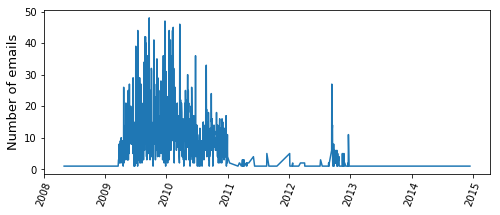

In [126]:
def plot_emails_frequencies(freq):
    plt.figure(figsize=(8,3))
    plt.plot(freq)
    plt.xticks(rotation=70)
    #plt.title("Occurrences of Hillary's emails", size=18)
    plt.ylabel("Number of emails", size=13)
    plt.show()

plot_emails_frequencies(emails_occurrences)

We see three interesting moments:

* from 2009 to 2011
* from 2011 to 2012 June (it looks like some emails have not been or could not be disclosed)
* from 2012 June to 2013

We introduce some external knowledge:

    2009.03.17: France joins (again) NATO.
    2009.04   : Swine flu
    2010.04.10: Polish president dies in plane crash in Russia
    2010.04.20: BP oil split
    2010.05.10: The Greek crisis
    2010.05.11: David Cameron becomes prime minister
    2010.05.31: Gaza flotilla raid
    2010.07   : Wikeleaks and Julian Assange
    2011.01.01: Dilma Roussef becomes president of Brazil
    2011.01.14: Ben Ali leaves Tunisia to Saudi Arabia
    2011.01.25: Revolution starts in Egypt
    2011.02.11: Hosni Moubarak resigns
    2011.02.17: Mouammar Kadhafi's problems start
    2011.03.11: Fukishima catastroph
    2011.02.15: It starts in Syria
    2011.07.22: Anders Behring Breivik in Norway
    2011.08   : Southern Israel cross-border attacks
    2011.10.20: Mouammar Kadhafi is killed

    2012.04   : Election in France
    2012.09.11: Christopher Stevens, US ambassador in Libya is killed
    2012.11.06: Barack Obama is elected

    2013.03.15: Hugo Chavez is dead

In [65]:
def get_by_context(docs, n):
    """Keep emails which are in context n"""
    if n == 0:
        (y1, m1, d1) = (2009, 1, 1)
        (y2, m2, d2) = (2011, 1, 1)
    elif n == 1:
        (y1, m1, d1) = (2011, 1, 1)
        (y2, m2, d2) = (2012, 6, 1)
    elif n == 2:
        (y1, m1, d1) = (2012, 6, 1)
        (y2, m2, d2) = (2013, 1, 1)
    else:
        raise ValueError
    tmp = docs.dropna(subset=['MetadataDateSent'])
    return tmp[(tmp.MetadataDateSent >= datetime(y1, m1, d1)) &\
               (tmp.MetadataDateSent <= datetime(y2, m2, d2))]

### Research of topics

It is time to show what words reveal.

In [66]:
emails_africa = emails[emails['africa']]
emails_central_asia = emails[emails['central_asia']]
emails_europe = emails[emails['europe']]
emails_far_east = emails[emails['far_east']]
emails_middle_east = emails[emails['middle_east']]
emails_latino = emails[emails['latino']]
emails_north_america = emails[emails['north_america']]
emails_russia = emails[emails['russia']]

In [67]:
def plot_distribution_email(context=None):
    labels = ('Africa', 'Central Asia', 'Europe', 'Far East', 'Middle East', 'North Amercia', 'Latino', 'Russia')
    y_pos = np.arange(len(labels))
    if context is None:
        title = 'Distribution of the emails'
        mail_count = [emails_africa.shape[0], emails_central_asia.shape[0], emails_europe.shape[0],
                      emails_far_east.shape[0], emails_middle_east.shape[0], emails_north_america.shape[0],
                      emails_latino.shape[0], emails_russia.shape[0]]
    else:
        if context == 0:
            (y1, m1, d1) = (2009, 1, 1)
            (y2, m2, d2) = (2011, 1, 1)
        elif context == 1:
            (y1, m1, d1) = (2011, 1, 1)
            (y2, m2, d2) = (2012, 6, 1)
        elif context == 2:
            (y1, m1, d1) = (2012, 6, 1)
            (y2, m2, d2) = (2013, 1, 1)
        else:
            raise ValueError
        
        title = 'Distribution of the emails from %d-%d-%d to %d-%d-%d' % (y1, m1, d1, y2, m2, d2)
        
        tmp_africa = get_by_context(emails_africa, context).shape[0]
        tmp_central_asia = get_by_context(emails_central_asia, context).shape[0]
        tmp_europe = get_by_context(emails_europe, context).shape[0]
        tmp_far_east = get_by_context(emails_far_east, context).shape[0]
        tmp_middle_east = get_by_context(emails_middle_east, context).shape[0]
        tmp_north_america = get_by_context(emails_north_america, context).shape[0]
        tmp_latino = get_by_context(emails_latino, context).shape[0]
        tmp_russia = get_by_context(emails_russia, context).shape[0]
        
        mail_count = [tmp_africa, tmp_central_asia, tmp_europe,
                      tmp_far_east, tmp_middle_east, tmp_north_america,
                      tmp_latino, tmp_russia]
    
    plt.figure(figsize=(9,4))
    plt.barh(y_pos, mail_count, align='center', alpha=1)
    plt.yticks(y_pos, labels)
    plt.xlabel('Number of emails')
    plt.title(title)

    plt.show()

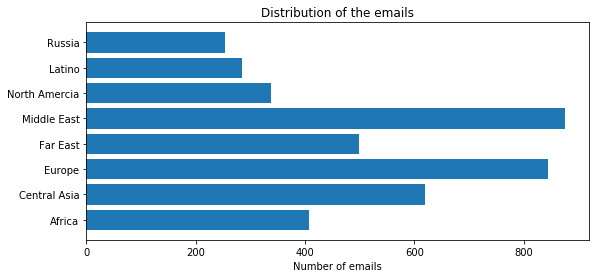

In [68]:
plot_distribution_email(None)

Some care is necessary before interpreting this plot. It is not a surprise that North America outnumbered the other places. Since the content of the emails are based from the American point of view, keyword extraction will consider more emails related to North America than we should.

In [69]:
def word_bar_plot(words, title, xlabel):
    '''Plot the horizontal bar chart for each region'''
    plt.figure(figsize=(15,7))
    plt.barh(range(len(words)),[val[1] for val in words], align='center')
    plt.yticks(range(len(words)), [val[0] for val in words])
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()

In [70]:
def get_top_words(corpus, words=None, n=30, tf_idf=True, plot=True):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    corpus = corpus.dropna()
    xlabel = 'Count words'
    
    if words is not None:
        corpus = corpus[corpus.str.contains(words)]

    if tf_idf:
        vec = TfidfVectorizer(ngram_range=(2,2)).fit(corpus)
        xlabel = 'Tf-Idf scores'
    else:
        vec = CountVectorizer(ngram_range=(2,2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    if plot:
        word_bar_plot(words_freq[:n], words, xlabel)
    return words_freq[:n]

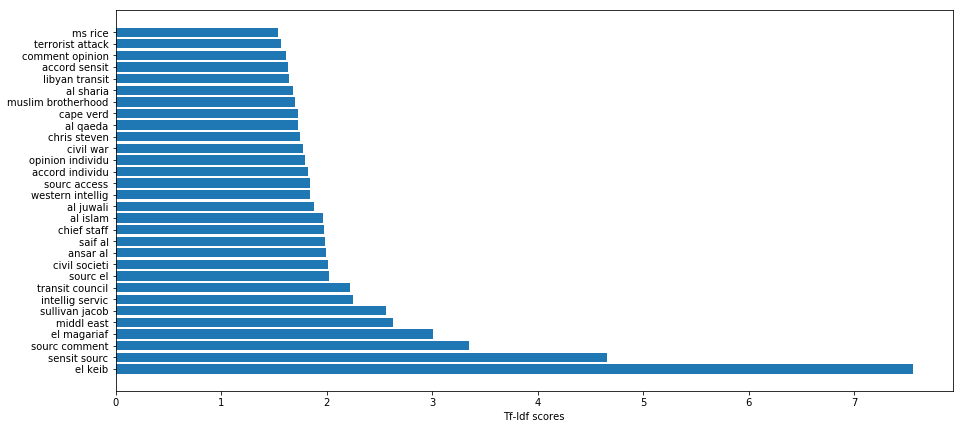

In [71]:
w = get_top_words(emails_africa.content, None)

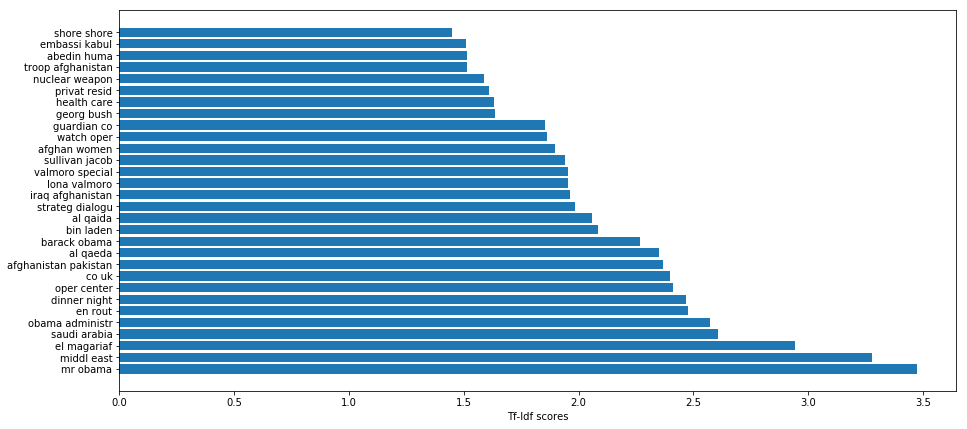

In [72]:
w = get_top_words(emails_central_asia.content, None)

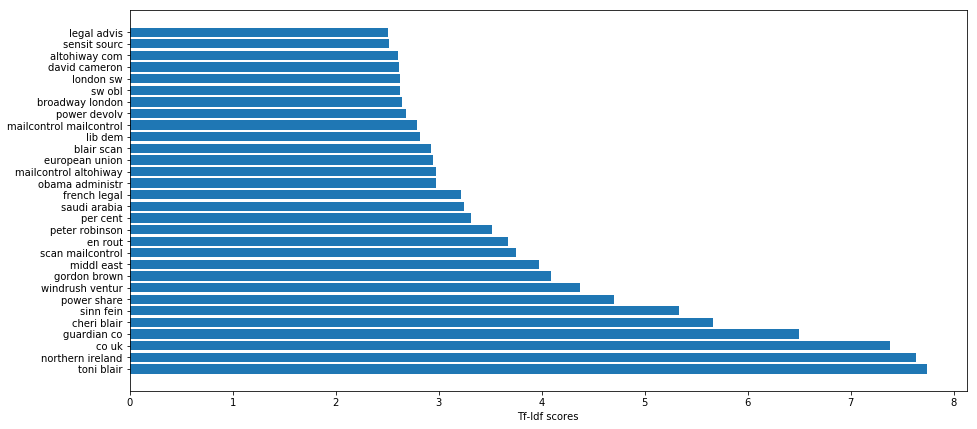

In [73]:
w = get_top_words(emails_europe.content, None)

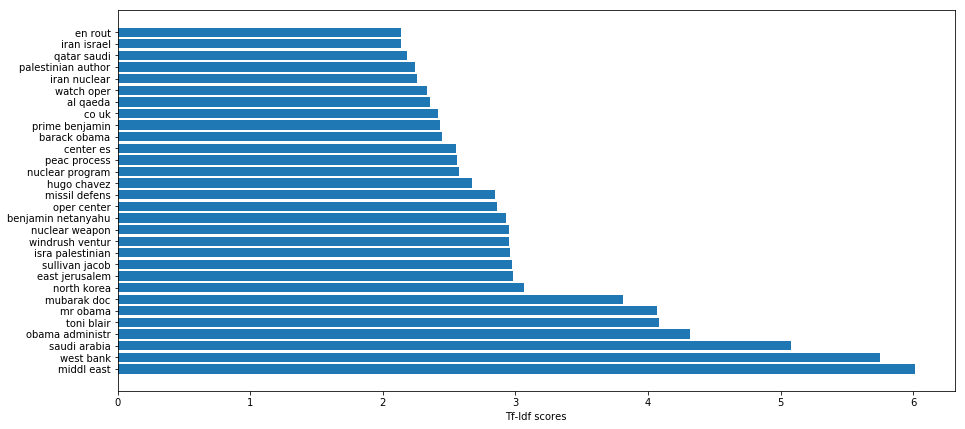

In [74]:
w = get_top_words(emails_middle_east.content, None)

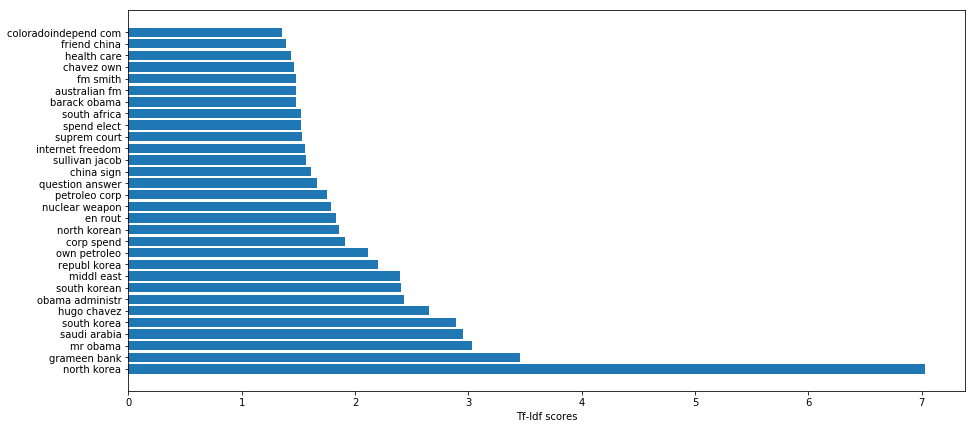

In [75]:
w = get_top_words(emails_far_east.content, None)

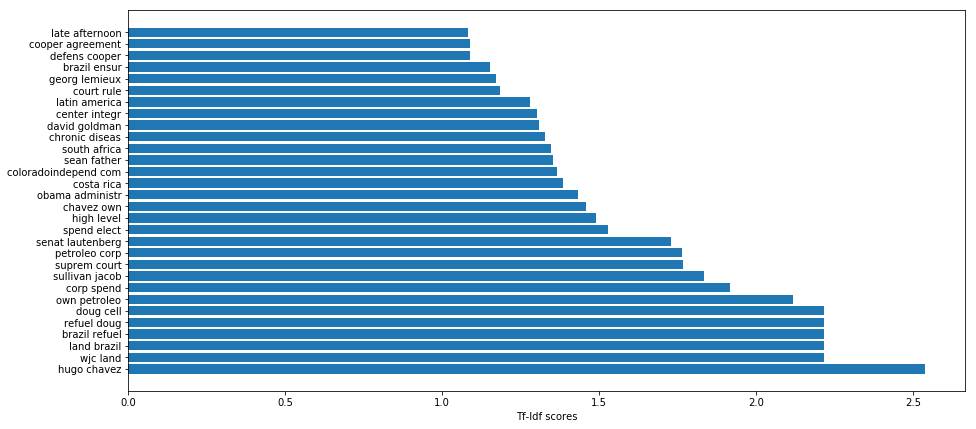

In [76]:
w = get_top_words(emails_latino.content, None)

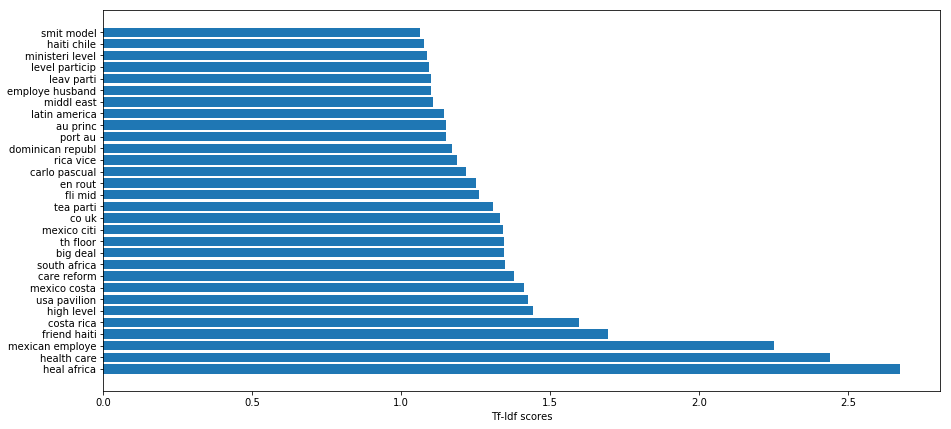

In [77]:
w = get_top_words(emails_north_america.content, None)

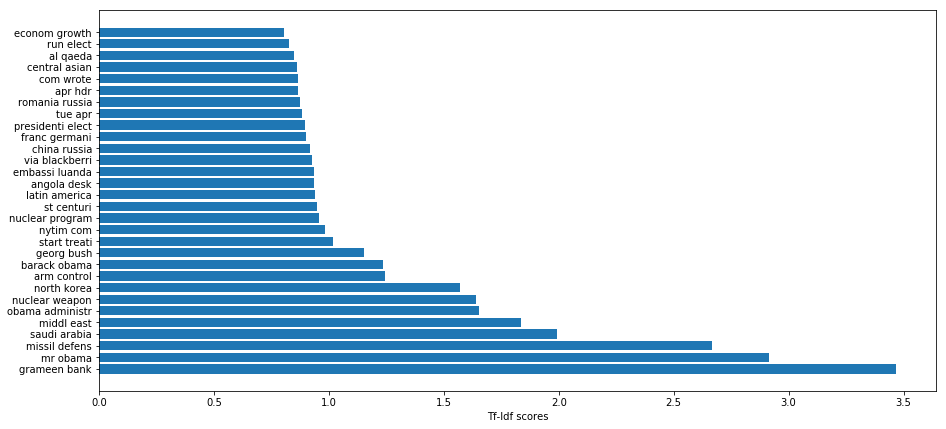

In [78]:
w = get_top_words(emails_russia.content, None)

Based on the horizontal plot for each region, we guess the main subjects are: (comment are done according to 1-gram and 2-grams)

* **Africa:** Human rights, Libya, policy transition, revolution of 2011.
* **Central Asia:** Human rights, Al Qaida, Ben Laden. Pakistan, Saudi Arabia.
* **Europe:** Climate change, European Union, UK, human rights.
* **Far East:** Petrol, climate change, human rights. Related to specific countries as North Korea, South Korea, Saudi Arabia
* **Middle east:** Human rights, peace, missile defense. Related to Israel, Palestine.
* **North America:** Health care, human rights are some subjects.
* **Latino:** Contains only around 250 emails for subjects completely different. Difficult to conclude anything.
* **Russia:** Missile defense, human rights, North Korean, arm control are some interesting subject related to Russia.

It is interesting to remark that the only subject that is shared everywhere is the Human Rights.

### Evolution of the distribution

We have seen that there are three moments which can be identified when looking at the plot of the number of emails per day. Let's have a look at it:

(Note the scale are different)

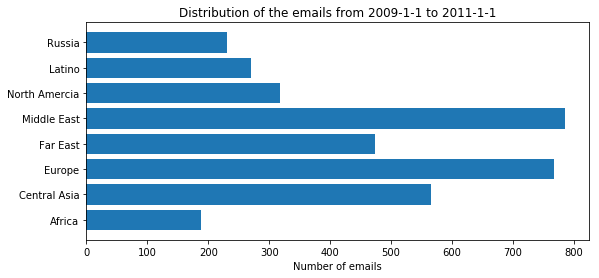

In [79]:
plot_distribution_email(0)

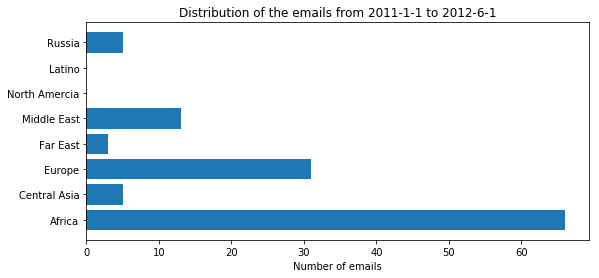

In [80]:
plot_distribution_email(1)

The above plot covers the Arab revolution in 2011 + NATO operation in Libya.

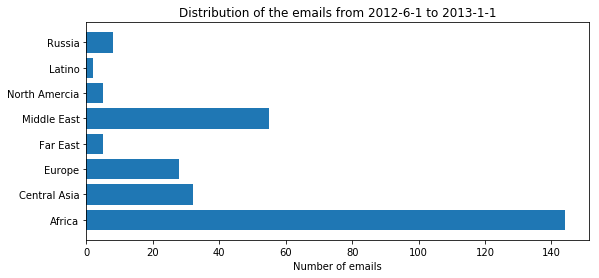

In [81]:
plot_distribution_email(2)

As we have said, the US ambassador for Libya was killed in September 2012. This is probably the reason why we have so many emails one year after Kaddafi.

## Visualization of the classes

If we compare the dataset we have with what we are used to have, then we can say our dataset is really small. However, it is still impossible for a human to read and group documents together. It is obvious we need an unsupervised algorithm. We hope the cosine distance between documents will reveal the number of classes per region and complete with external knowledge to name them.

The dendogram code is taken from [here](http://brandonrose.org/clustering) on November 24th 2018.

In [82]:
# Dendogram
def plot_dendogram(context):
    emails_filtered = get_by_context(emails, context).content
    
    tfidf_matrix = Analyse.tfidf_matrix(emails_filtered)
    dist = 1 - cosine_similarity(tfidf_matrix)
    linkage_matrix = ward(dist)
    
    fig, ax = plt.subplots(figsize=(15, 7)) # set size
    ax = dendrogram(linkage_matrix, orientation="top")

    plt.tick_params(\
        axis= 'x',         # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)

    plt.tight_layout() #show plot with tight layout

In [83]:
# plot_dendogram(0) # context 0 Please do not run this cell
# because it contains to many data

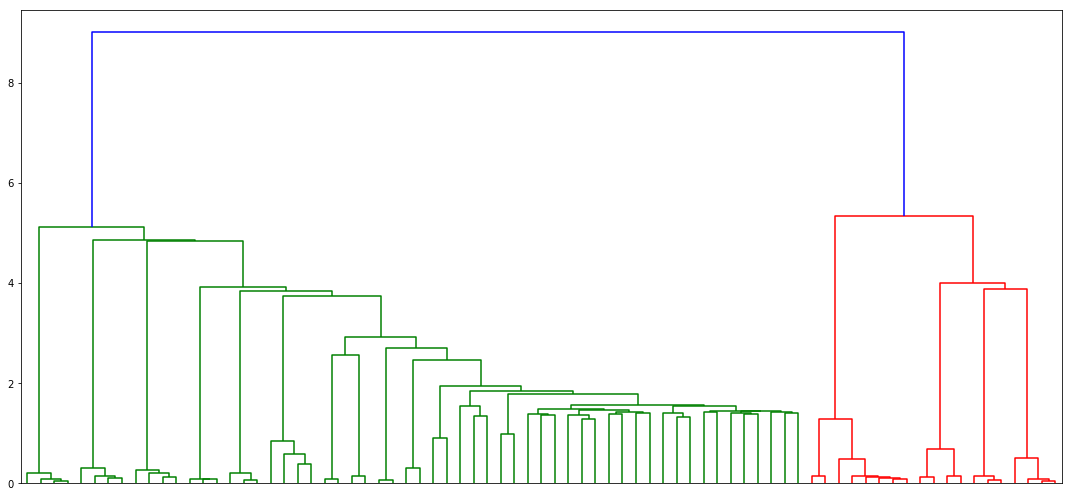

In [84]:
plot_dendogram(1) # context 1

We observe two categories. One of them is likely to be or to contain the NATO operation in Libya against Kaddafi.

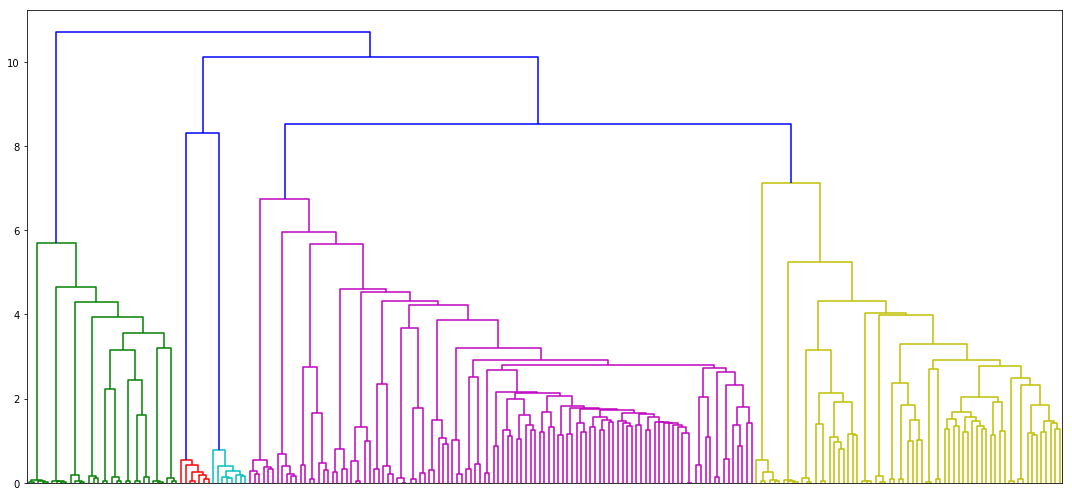

In [85]:
plot_dendogram(2) # context 2

Now it is time to find a name for the clusters.

In [86]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle

In [87]:
from nltk.corpus import PlaintextCorpusReader
contexts = PlaintextCorpusReader(PATH_TO_GENERATED, '.*.txt')
print(contexts.fileids())

['sentences_ctx0.txt', 'sentences_ctx1.txt', 'sentences_ctx2.txt']


Extracting topics from a set of content is a known exercise. We know from the tutorial how to get the topics for each book among many books. We adapt the input the following way. We create a set of sentences for each context which can be seen as a book.

In [88]:
def get_chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]


# Get the data
book_id = {f:n for n,f in enumerate(contexts.fileids())} # dictionary of books

chunks = list()
chunk_class = list() # this list contains the original book of the chunk, for evaluation

limit = 500 # how many chunks total
size = 50 # how many sentences per chunk/page

for f in contexts.fileids():
    sentences = contexts.sents(f)
    print(f,":")
    print('Number of sentences:',len(sentences))
    
    # create chunks
    chunks_of_sents = [x for x in get_chunks(sentences,size)] # this is a list of lists of sentences, which are a list of tokens
    chs = list()
    
    # regroup so to have a list of chunks which are strings
    for c in chunks_of_sents:
        grouped_chunk = list()
        for s in c:
            grouped_chunk.extend(s)
        chs.append(" ".join(grouped_chunk))
    print("Number of chunks:", len(chs), '\n')
    
    # filter to the limit, to have the same number of chunks per book
    chunks.extend(chs[:limit])
    chunk_class.extend([book_id[f] for _ in range(len(chs[:limit]))])

sentences_ctx0.txt :
Number of sentences: 86073
Number of chunks: 1722 

sentences_ctx1.txt :
Number of sentences: 2220
Number of chunks: 45 

sentences_ctx2.txt :
Number of sentences: 6712
Number of chunks: 135 



In [89]:
def output_topics(context):    
    vectorizer = CountVectorizer()

    #create bag of words features
    X = vectorizer.fit_transform(chunks)

    Y = np.array(chunk_class) == context
    Y = Y.astype(int)  

    #shuffle the data
    X, Y = shuffle(X, Y, random_state=0)

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    
    #the grid of regularization parameter 
    grid = [0.01,0.1,1,10,100,1000,10000]

    best_regularization = grid[-1]
    previous_score = -1
    
    for c in grid:
        clf = LogisticRegression(random_state=0, solver='lbfgs', C=c)
        scores = cross_val_score(clf, X_train,Y_train, cv=10)
        score = np.mean(scores)
        if score < previous_score:
            break
        best_regularization = c
    
    clf = LogisticRegression(random_state=0, solver='lbfgs', C=best_regularization).fit(X_train,Y_train)

    #predict on the test set
    coefs = clf.coef_[0]
    top_three = np.argpartition(coefs, -25)[-25:]

    print(np.array(vectorizer.get_feature_names())[top_three])

In [90]:
output_topics(0) # from 2009 to 2011

['fax' 'process' 'result' 'fill' 'push' 'interrog' 'holbrook' 'tom'
 'propos' 'copi' 'china' 'rais' 'institut' 'blackberri' 'letter'
 'statement' 'iraqi' 'got' 'jim' 'cdm' 'confirm' 'home' 'speech' 'attach'
 'pls']


In [91]:
output_topics(1) # from 2011 to 2012 June

['rwanda' 'nato' 'implement' 'ntc' 'hunger' 'sullivan' 'global' 'belhaj'
 'flight' 'arab' 'rebel' 'keib' 'zone' 'egypt' 'el' 'qadhafi' 'qaddafi'
 'provid' 'jacob' 'steven' 'food' 'tnc' 'saif' 'inc' 'initi']


In [92]:
output_topics(2) # from 2012 June to 2013

['gregori' 'bank' 'violenc' 'king' 'dan' 'consul' 'benghazi' 'muslim'
 'magariaf' 'question' 'libyan' 'protest' 'protect' 'libya' 'ambassador'
 'rice' 'grameen' 'diplomat' 'risk' 'morocco' 'gnc' 'intellig' 'monica'
 'romney' 'attack']


In [119]:
model.wv.most_similar(positive=["iraq", "china"], topn=20)

[('pakistan', 0.816469132900238),
 ('iran', 0.8070544004440308),
 ('nuclear', 0.79380202293396),
 ('altai', 0.7763460278511047),
 ('russia', 0.7678554058074951),
 ('strain', 0.732358992099762),
 ('afghanistan', 0.724134624004364),
 ('tension', 0.7194409966468811),
 ('crise', 0.7190180420875549),
 ('india', 0.7185169458389282),
 ('britain', 0.7150052785873413),
 ('powerhous', 0.7128200531005859),
 ('sanction', 0.7038410902023315),
 ('steadili', 0.700823187828064),
 ('japan', 0.6989964246749878),
 ('countervail', 0.6980704069137573),
 ('mainland', 0.6848052740097046),
 ('clergi', 0.6835923790931702),
 ('smarter', 0.6829358339309692),
 ('toward', 0.6800622344017029)]

For the context 0: Subjects seem to be dominated by Asia, from Iraq to Japan but mainly by China. For the context 1: The NATO operation which lead to the death of Quaddafi is the main subject For the context 2: The death of the US ambassador dominates the topics detected.

## Word-Cloud

In [94]:
from wordcloud import WordCloud

In [95]:
import wordcloud
print(wordcloud._version)

<module 'wordcloud._version' from '/home/ginger/anaconda3/lib/python3.6/site-packages/wordcloud/_version.py'>


In [96]:
def wordcloud_visualization(contents, huge=True):
    wordcloud = WordCloud(background_color="white").generate(str(contents))
    if huge:
        fig, ax = plt.subplots(figsize=(15, 20))
    else:
        fig, ax = plt.subplots(figsize=(6, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

We show word-clouds for each region before showing it for each 'ctx'.

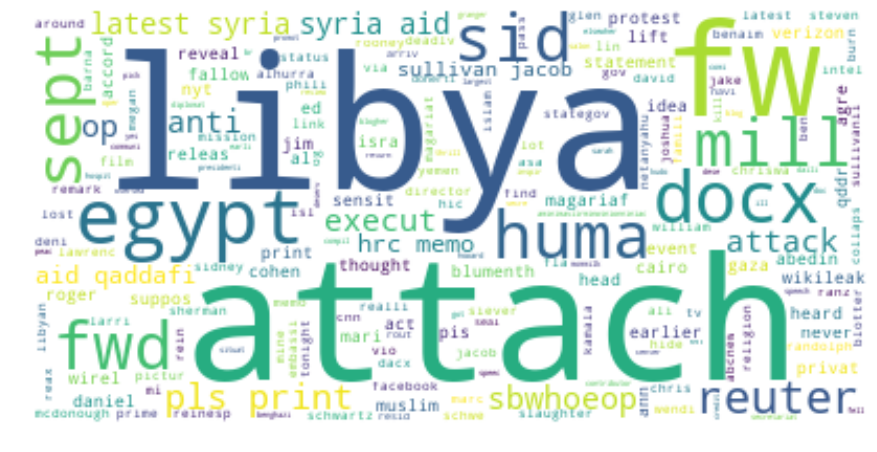

In [97]:
wordcloud_visualization(emails_africa.content)

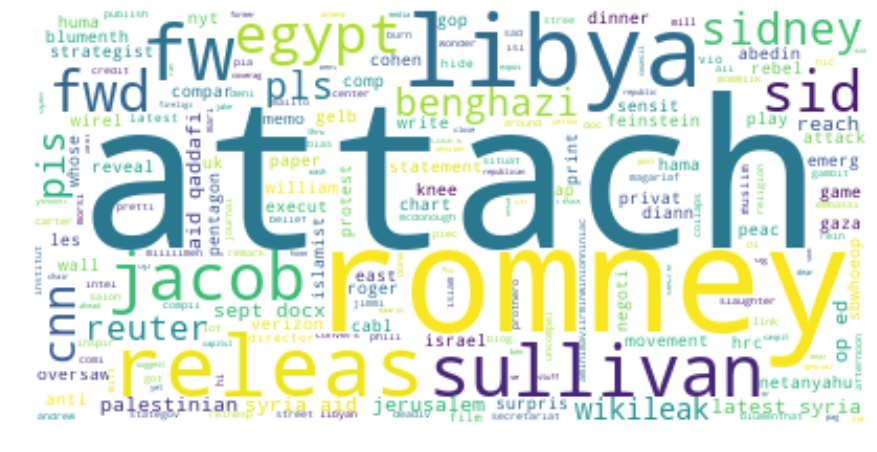

In [98]:
wordcloud_visualization(emails_middle_east.content)

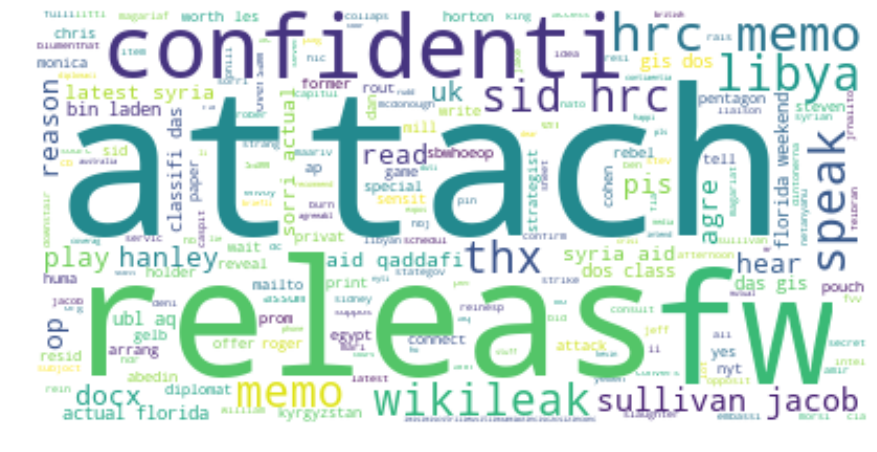

In [99]:
wordcloud_visualization(emails_europe.content)

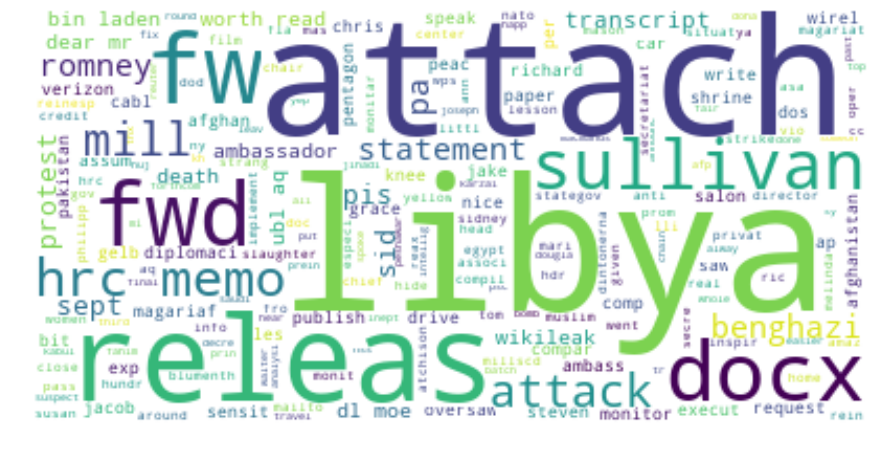

In [100]:
wordcloud_visualization(emails_central_asia.content)

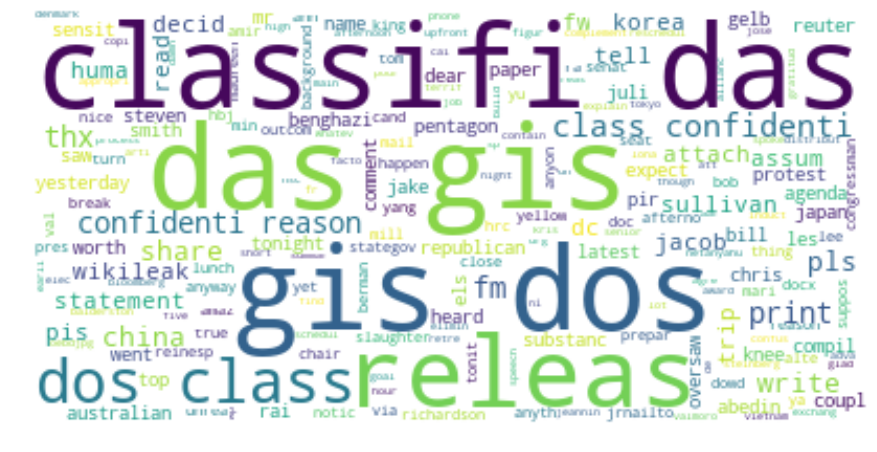

In [101]:
wordcloud_visualization(emails_far_east.content)

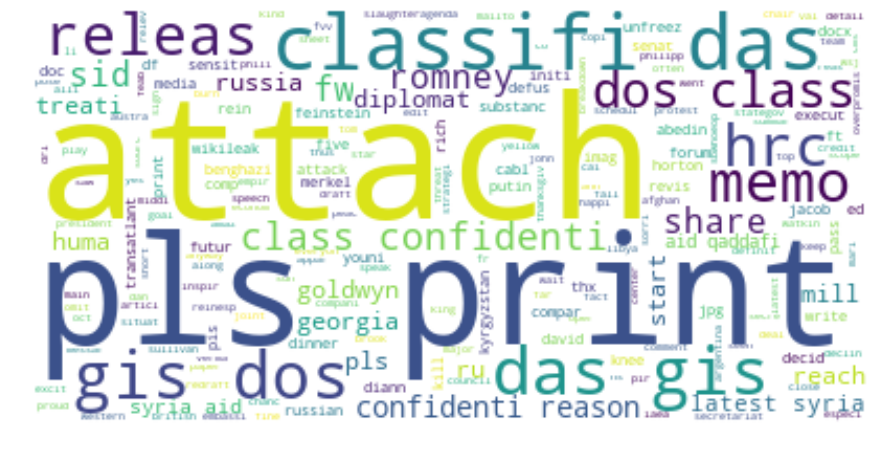

In [102]:
wordcloud_visualization(emails_russia.content)

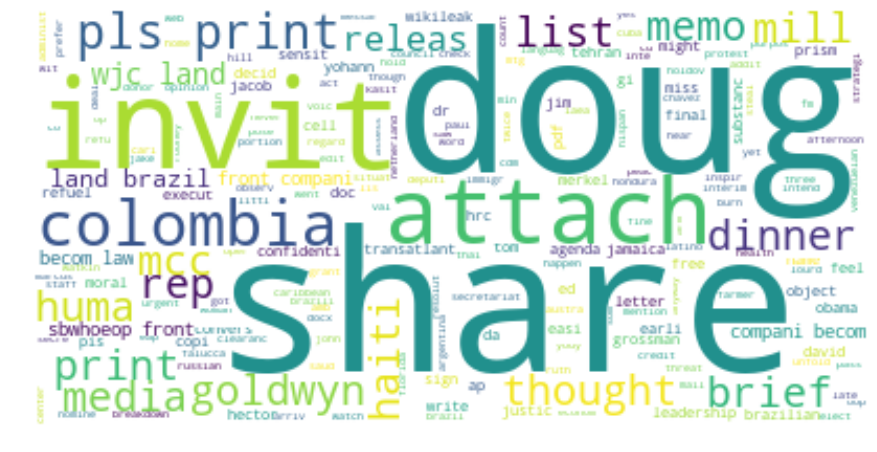

In [103]:
wordcloud_visualization(emails_latino.content)

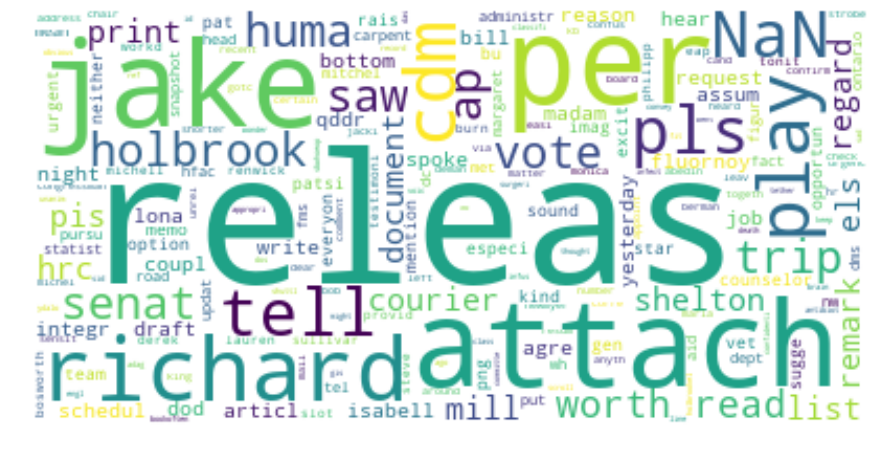

In [104]:
wordcloud_visualization(get_by_context(emails, 0).content, True) # emails of context 0

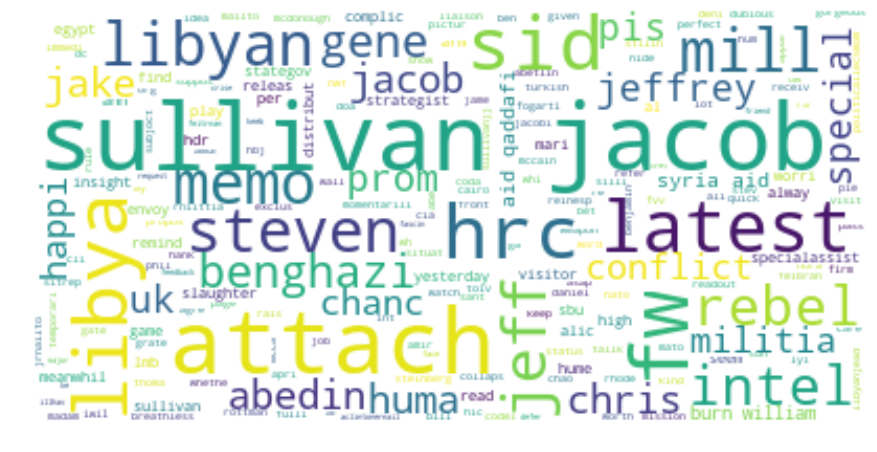

In [105]:
wordcloud_visualization(get_by_context(emails, 1).content, True) # emails of context 1

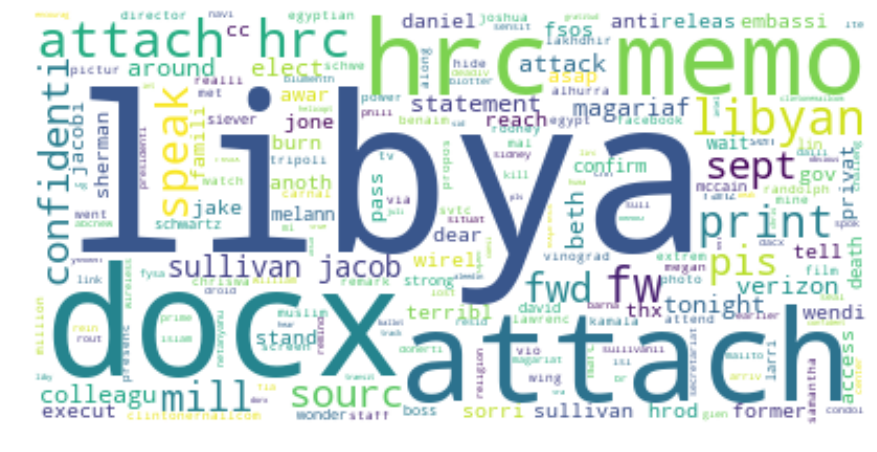

In [106]:
wordcloud_visualization(get_by_context(emails, 2).content, True) # emails of context 2

## Hillary's Network

In this part, we provide the Hillary's Network. In order to get readable results and graphs, we focus on the most important exchange of her Network. Since we are interesting in the networks, we consider an undirected graph.

Again, we will first write the functions which creates the data structure we want with the parameters we want. Since the context number 0 is the one which contains almost all emails. Therefore, we will show a graph for each context.

It is also possible to set the minimum weight of an edge to be shown. This is useful when the number of edges makes the graph impossible to read and to show strong connection as well.

In [107]:
def get_from_to(context=None):
    """Get author and all dest."""
    def get_from_field(eid, to):
        """Get the value of the `from` field."""
        tmp = emails[(emails.Id == eid) & (emails.to != to)]['from']
        if len(tmp.values):
            return int(tmp.values[0])
        else:
            return np.nan # we will not count 'cc' and 'to' two times if same value

    # here we build the two df we will concatenate
    eid_from_cc = table_cc[['EmailId', 'PersonId']].copy()
    eid_from_cc['from'] = eid_from_cc.apply(lambda r: get_from_field(r['EmailId'], r['PersonId']), axis=1)
    eid_from_cc.columns = ['Id', 'to', 'from']
    eid_from_cc = pd.merge(eid_from_cc, emails, left_on="Id", right_on="Id")[['MetadataDateSent', 'from_x', 'to_x']]
    eid_from_cc.columns = ['date', 'from', 'to']

    eid_from_to = emails[['MetadataDateSent', 'from', 'to']].copy()
    eid_from_to.columns = ['date', 'from', 'to']

    eid_from_to = eid_from_to[eid_from_to['from'] != eid_from_to['to']].dropna() # remove self edge
    eid_from_cc = eid_from_cc[eid_from_cc['from'] != eid_from_cc['to']].dropna() # remove self edge

    eid_from_to = eid_from_to.append(eid_from_cc, ignore_index=True)
    
    # Here we filter by context
    if context is None:
        return eid_from_to[['from', 'to']].astype(int)
    elif context == 0:
        (y1, m1, d1) = (2009, 1, 1)
        (y2, m2, d2) = (2011, 1, 1)
    elif context == 1:
        (y1, m1, d1) = (2011, 1, 1)
        (y2, m2, d2) = (2012, 6, 1)
    else:
        (y1, m1, d1) = (2012, 6, 1)
        (y2, m2, d2) = (2013, 1, 1)
    return eid_from_to[(eid_from_to.date >= datetime(y1, m1, d1)) &\
               (eid_from_to.date <= datetime(y2, m2, d2))][['from', 'to']].astype(int)

In [108]:
def plot_persons_occurence(context=None):
    eid_from_to = get_from_to(context)
    
    from_count = pd.value_counts(eid_from_to['from'])
    to_count = pd.value_counts(eid_from_to['to'])

    tmp = pd.merge(from_count.reset_index(), persons, left_on="index", right_on="Id")[["Name", "from"]]
    tmp.set_index("Name").head(20).plot.barh()
    #
    tmp = pd.merge(to_count.reset_index(), persons, left_on="index", right_on="Id")[["Name", "to"]]
    tmp.set_index("Name").head(20).plot.barh()

Now that we have our function to get and plot data, we can choose the context. We expect Hilary Clinton to be the one who receives the more emails.

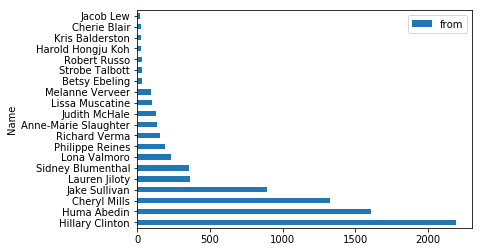

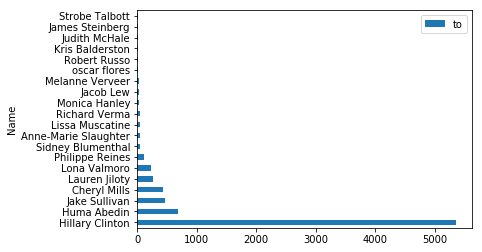

In [109]:
plot_persons_occurence(context=0)

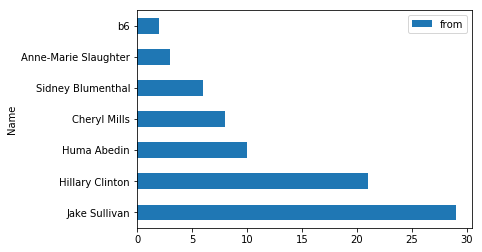

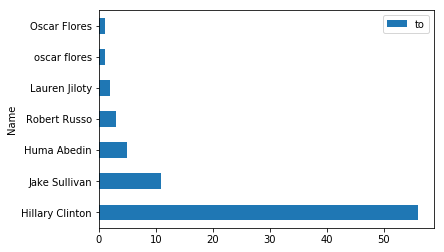

In [110]:
plot_persons_occurence(context=1)

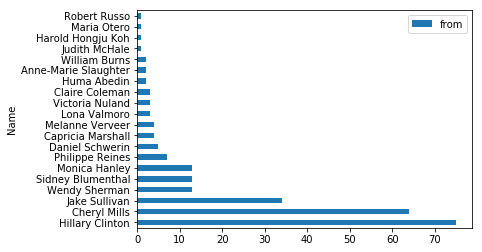

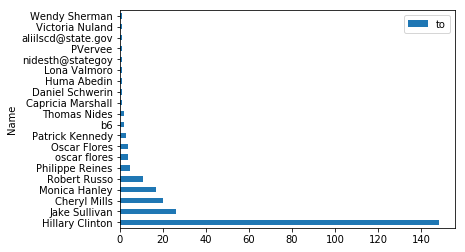

In [111]:
plot_persons_occurence(context=2)

In [112]:
import networkx as nx

In [113]:
def set_edge(a, b):
    if a < b:
        return (a, b)
    else:
        return (b, a)

def show_network(context=None, minium_weight=0, label=False):
    """Show a graph with nodes having at least one edge of weight given and for a given context"""
    G = nx.Graph()
    edges = set()
    eid_from_to = get_from_to(context)
    eid_from_to['edge'] = eid_from_to.apply(lambda r: set_edge(r['from'], r['to']), axis=1)
    eid_from_to_significant = pd.concat(r for (_, r) in eid_from_to.groupby(['from', 'to']) \
                                        if len(r) >= minium_weight).reset_index()    
    for i in range(0, len(eid_from_to_significant)):
        a = eid_from_to_significant.edge[i][0]
        b = eid_from_to_significant.edge[i][1]    
        G.add_node(a)
        G.add_node(b)
        if (a, b) not in edges:
            G.add_edge(a, b)
    nx.draw_spring(G, with_labels=label,  alpha = 0.7)

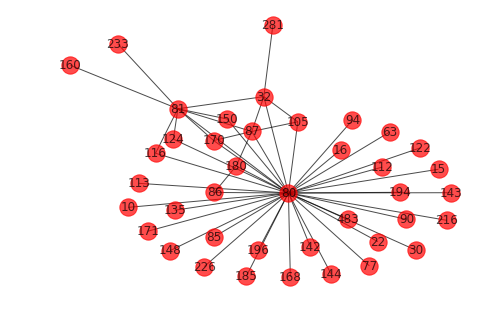

In [124]:
show_network(0, 8, True) # minimum edge of weight 8 for the 1st period

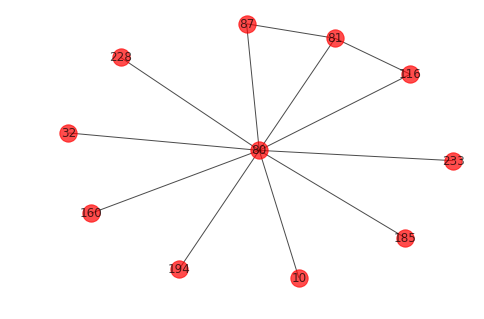

In [123]:
show_network(1, 0, True)  # minimum edge of weight 0 for the 2nd period

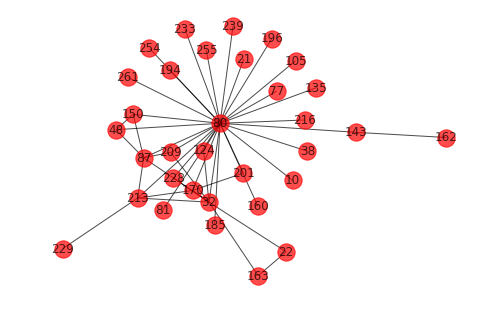

In [116]:
show_network(2, 0, True)  # minimum edge of weight 0 for the 3rd period

In [117]:
# change the line below to see the name behind the number on each node
relevant_nodes = [10, 32, 81, 87, 157]
persons[persons.Id.isin(relevant_nodes)]

Id                  Name  newId
9     10  Anne-Marie Slaughter     10
31    32          Cheryl Mills     32
80    81           Huma Abedin     81
86    87         Jake Sullivan     87
156  157              Nora Tov    157

The frequency of the messages received or sent changes in time. The topics and words changes too. However, we see the same names during each moment. We can interpret it the following way: there is a hierarchy and those people are closer to Hillary Clinton than the others. Actually these people are her political advisers.

## Future work

Hillary Clinton emails is a huge subject and we have only cover a small subset of what could have been done. The pipeline we have set up for the analysis shows it is easy to extract topics automatically, even basic system such as the one based on key words can reveal a lot of information. However, external knowledge is still necessary at least to interpret results.

The current work can be improved by a better text processing. We have used stemming but lemnatization could change some output. The dataset contains likely personal and professional emails, it is possible to identify them by identifying the private contact in the graph: running the machine learning algorithm on each of them could show private topics like [Monica Lewinsky](https://en.wikipedia.org/wiki/Monica_Lewinsky)...

In the end, we can say it is a bad idea to mix private and professional tools which can lead to dangerous (and embarrassing) leaks. This may also reduce the number of burn out and improve the well-being of people.